In [3]:
from google.colab import files
uploaded = files.upload()  # Upload the zipped dataset


Saving EuroSAT.zip to EuroSAT.zip


In [4]:
import zipfile
import os

# Unzip the uploaded file
zip_filename = list(uploaded.keys())[0]  # Get uploaded file name
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall('./data')  # Extract to a "data" directory

# Set the directory for the dataset
train_dir = './data/2750'


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator()
train_generator = datagen.flow_from_directory(train_dir)
class_names = list(train_generator.class_indices.keys())
print("Class Names:", class_names)


Found 27000 images belonging to 10 classes.
Class Names: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score, log_loss
import pandas as pd



In [7]:
img_height, img_width = 224, 224   # VGG16 default input size
batch_size = 32
num_classes = 10                   # Change based on dataset
epochs = 10

In [8]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # VGG16 Preprocessing
    validation_split=0.2,  # 80% train, 20% validation
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [9]:
val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2  # 20% validation split
)



In [10]:

# Training Data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'  # 80% training data
)



Found 21600 images belonging to 10 classes.


In [11]:
# Validation Data
validation_generator = val_datagen.flow_from_directory(
   train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  # 20% validation data
)


Found 5400 images belonging to 10 classes.


In [12]:

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))



58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
for layer in base_model.layers:
    layer.trainable = False


In [14]:
# Add custom classification layers
x = base_model.output
x = Flatten(name='flatten')(x)
x = Dense(256, activation='relu', name='fc1')(x)
x = Dropout(0.5, name='dropout')(x)
predictions = Dense(num_classes, activation='softmax', name='predictions')(x)

model_vgg16 = Model(inputs=base_model.input, outputs=predictions)



In [15]:
# Compile the model
model_vgg16.compile(optimizer=Adam(learning_rate=1e-4),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

model_vgg16.summary()



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 21,140,042 (80.64 MB)

 Trainable params: 6,425,354 (24.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [16]:
# Train the Model
history = model_vgg16.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 314s 446ms/step - accuracy: 0.5839 - loss: 1.9144 - val_accuracy: 0.8620 - val_loss: 0.4548
Epoch 2/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 322s 476ms/step - accuracy: 0.7969 - loss: 0.6562 - val_accuracy: 0.8903 - val_loss: 0.3678
Epoch 3/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 322s 477ms/step - accuracy: 0.8282 - loss: 0.5386 - val_accuracy: 0.9027 - val_loss: 0.3256
Epoch 4/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 382s 477ms/step - accuracy: 0.8413 - loss: 0.5017 - val_accuracy: 0.9098 - val_loss: 0.3130
Epoch 5/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 301s 446ms/step - accuracy: 0.8513 - loss: 0.4743 - val_accuracy: 0.9165 - val_loss: 0.2827
Epoch 6/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 322s 445ms/step - accuracy: 0.8621 - loss: 0.4324 - val_accuracy: 0.9159 - val_loss: 0.2890
Epoch 7/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 299s 443ms/step - accuracy: 0.8647 - loss: 0.4307 - val_accuracy: 0.9195 - val_loss: 0.2762
Epoch 8/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 322s 443ms/step - accuracy: 0.8716 -

In [17]:
model_vgg16.save('vgg16_lulc_model10.h5')

In [18]:
y_true = validation_generator.classes  # True labels
y_pred_probs = model_vgg16.predict(validation_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

169/169 ━━━━━━━━━━━━━━━━━━━━ 37s 213ms/step


In [19]:
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nClassification Report:\n", classification_report(y_true, y_pred))

Accuracy: 0.1035
Precision: 0.1033
Recall: 0.1035
F1 Score: 0.1034

Classification Report:
               precision    recall  f1-score   support

           0       0.13      0.12      0.13       600
           1       0.11      0.11      0.11       600
           2       0.12      0.13      0.12       600
           3       0.06      0.06      0.06       500
           4       0.10      0.10      0.10       500
           5       0.09      0.09      0.09       400
           6       0.08      0.08      0.08       500
           7       0.11      0.12      0.11       600
           8       0.10      0.10      0.10       500
           9       0.12      0.12      0.12       600

    accuracy                           0.10      5400
   macro avg       0.10      0.10      0.10      5400
weighted avg       0.10      0.10      0.10      5400



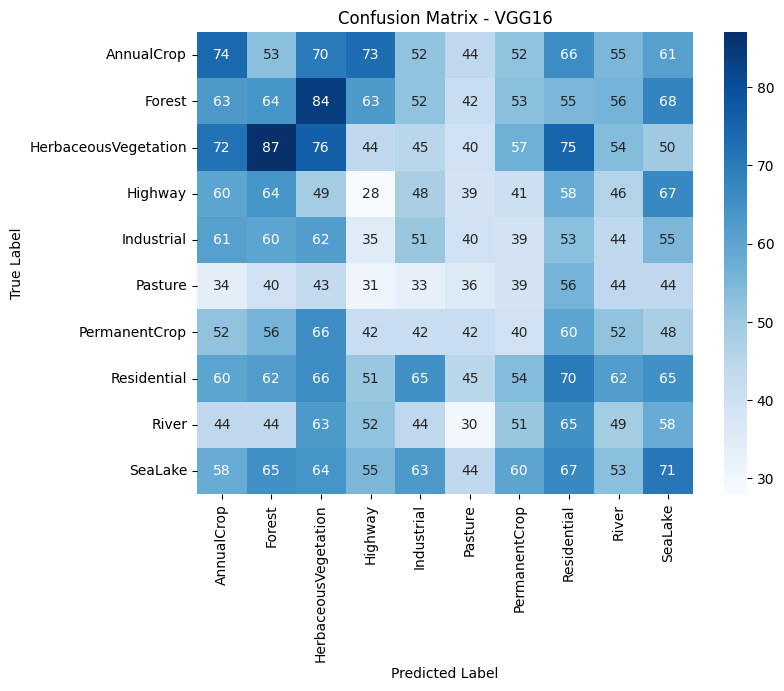

In [20]:
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=train_generator.class_indices.keys(), yticklabels=train_generator.class_indices.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - VGG16")
plt.show()


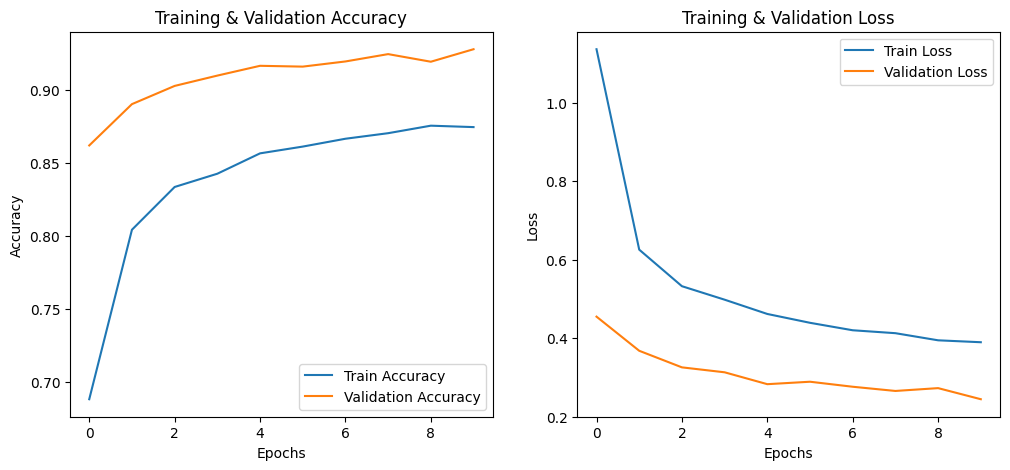

In [21]:
# Plot Training Curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.show()

In [22]:
from google.colab import files  # Only needed if using Google Colab

# Download the model (for local Jupyter Notebook or Colab)
files.download('vgg16_lulc_model10.h5')



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:


# Step 1: Upload the model and image files to Colab
from google.colab import files

# Upload model file
uploaded_model = files.upload()

# Upload image file for inference
uploaded_image = files.upload()

# Step 2: Import necessary libraries and load the model
from keras.models import load_model
import numpy as np
from tensorflow.keras.preprocessing import image

# Load the saved model
model = load_model(list(uploaded_model.keys())[0])  # Load the uploaded model file

# Step 3: Load and preprocess the image for inference
def preprocess_image(img, target_size=(224, 224)):
    img = image.load_img(img, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize the image
    return img_array

# Get the uploaded image filename
image_filename = list(uploaded_image.keys())[0]

# Preprocess the uploaded image
preprocessed_image = preprocess_image(image_filename)

# Step 4: Make the prediction
predictions = model.predict(preprocessed_image)

# Step 5: Get the predicted class (assuming 6 classes, change accordingly)
predicted_class = np.argmax(predictions, axis=1)

# Correctly extract the integer value from the NumPy array
predicted_class_index = predicted_class[0]  # Extract the integer index
predicted_class_name = class_names[predicted_class_index]  # Use the index to get the class name

# Print the results
print("predicted:",predicted_class)
print("Predicted Class Index:", predicted_class_index)
print("Predicted Class Name:", predicted_class_name)

